# Iteration 1 - TableNet Model Testing

> **Model**: TableNet Model <br/>
> **Creator**: Ryo

### Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog
import pytesseract
from PIL import Image
import plotly.graph_objects as go

# Specify the Tesseract command location for Windows
pytesseract.pytesseract.tesseract_cmd = r'D:\Software\Tesseract-OCR\tesseract.exe'

### Load Model

#### *Function*

In [2]:
def load_model_from_file(model_path):
    """
    Load the deep learning model for table detection.

    Parameters:
        model_path (str): Path to the .h5 file of the model.
    
    Returns:
        model: Loaded model for prediction.
    """
    # Step 1: Load the model from the specified path
    model = load_model(model_path)
    return model

#### *Implementation*

In [3]:
model_path = 'tablenet_model.h5'
model = load_model_from_file(model_path)

### Select Image

#### *Function*

In [4]:
def select_image_file():
    """
    Open a file dialog to select an image file for local testing.

    Returns:
        str: Path of the selected image file.
    """
    # Step 1: Open a file dialog to select the image
    Tk().withdraw()  # Hide the root window
    image_path = filedialog.askopenfilename(
        title="Select an Image File", 
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.tiff *.tif")]
    )
    return image_path

#### *Implementation*

In [5]:
image_path = select_image_file()

### Load and Preprocess Image

#### *Function*

In [6]:
def load_and_preprocess_image(image_path, image_size=(1024, 1024)):
    """
    Load and preprocess the image for model prediction.

    Parameters:
        image_path (str): Path of the selected image file.
        image_size (tuple): Size to which the image is resized for the model.

    Returns:
        tuple: The resized and original images.
    """
    # Step 1: Read the image from the path
    original_image = cv2.imread(image_path)
    
    # Step 2: Convert the image from BGR to RGB
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Step 3: Resize the image to the target size
    resized_image = cv2.resize(original_image, image_size)
    
    return resized_image, original_image

#### *Implementation*

In [7]:
resized_image, original_image = load_and_preprocess_image(image_path)

### Predict and Visualize

#### *Function*

In [8]:
def predict_and_visualize(model, resized_image, original_image):
    """
    Run prediction on the image and visualize the original, table mask, and column mask.

    Parameters:
        model: Loaded model for table detection.
        resized_image: Preprocessed image to be input into the model.
        original_image: Original image before preprocessing.

    Returns:
        np.array: Table mask from the model prediction.
    """
    # Step 1: Run the prediction using the model
    predictions = model.predict(resized_image[np.newaxis, ...] / 255.0)
    
    # Step 2: Extract the table and column masks
    table_mask = predictions[1][0, ..., 0]
    column_mask = predictions[0][0, ..., 0]
    
    # Step 3: Visualize the original image, table mask, and column mask side by side
    plt.figure(figsize=(20, 8))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Input Image')
    plt.axis('off')
    
    # Table Mask
    plt.subplot(1, 3, 2)
    plt.imshow(table_mask, cmap='gray')
    plt.title('Predicted Table Mask')
    plt.axis('off')
    
    # Column Mask
    plt.subplot(1, 3, 3)
    plt.imshow(column_mask, cmap='gray')
    plt.title('Predicted Column Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return table_mask

#### *Implementation*

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


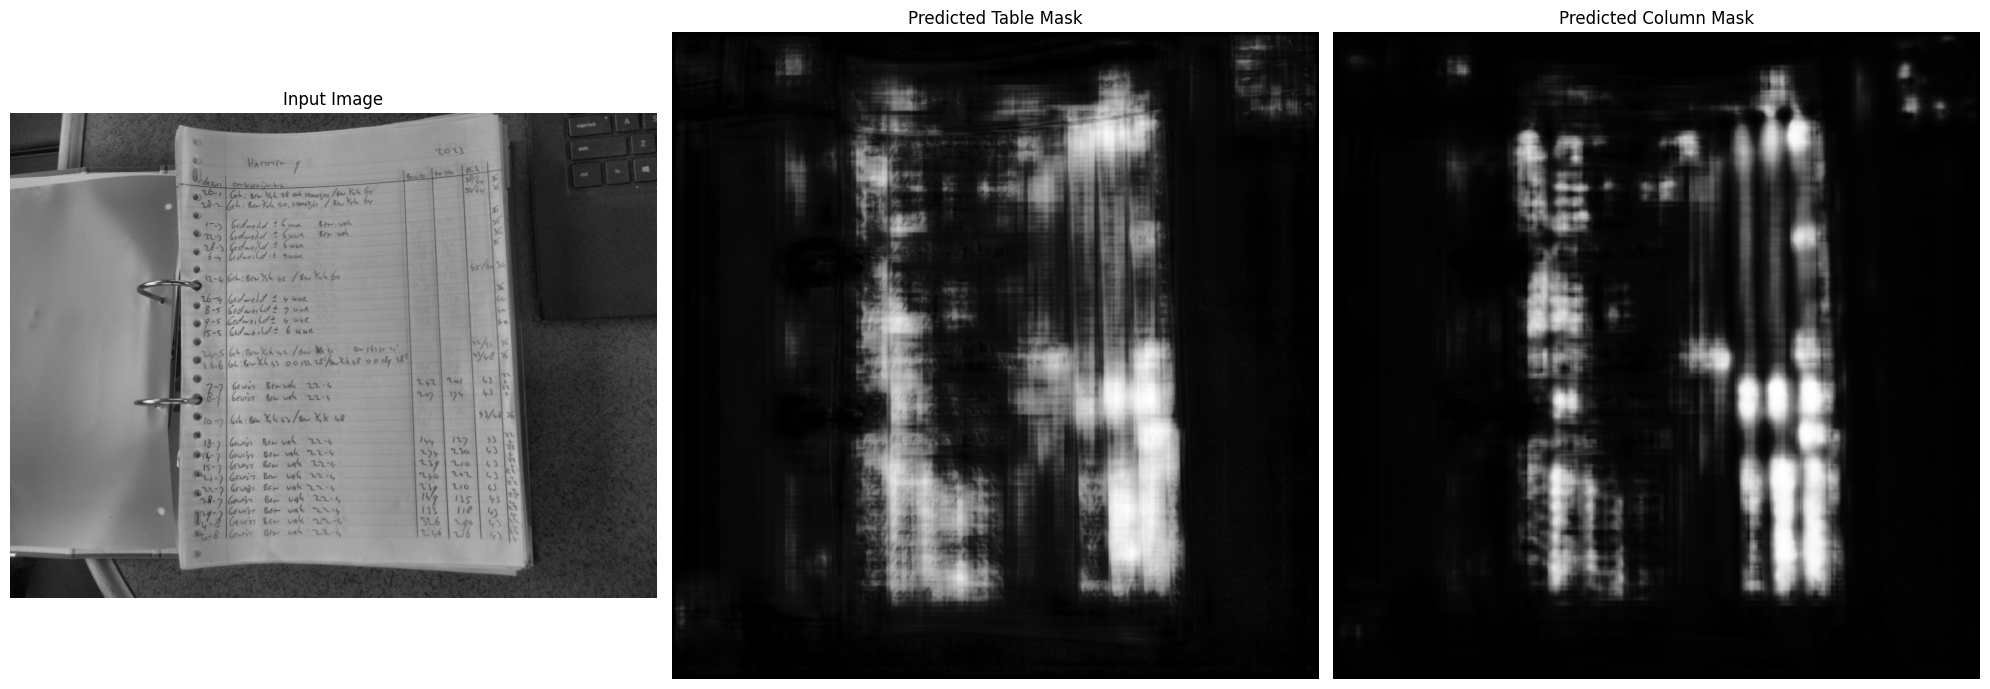

In [9]:
table_mask = predict_and_visualize(model, resized_image, original_image)

### Detect Table Areas

#### *Function*

In [10]:
def detect_table_areas(mask, image, threshold=0.1, min_area=500):
    """
    Efficiently detect table areas from the mask using contours and thresholding.

    Parameters:
        mask (np.array): Mask image for table detection.
        image (np.array): Original image to match the mask size.
        threshold (float): Threshold for binarizing the mask.
        min_area (int): Minimum area threshold for contour detection.

    Returns:
        list: Detected contours above the minimum area.
    """
    # Step 1: Perform thresholding to binarize the mask
    binary_mask = (mask > threshold).astype(np.uint8) * 255

    # Step 2: Detect contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Filter only large contours based on minimum area
    large_contours = [c for c in contours if cv2.contourArea(c) >= min_area]

    return large_contours

### Visualize Detected Table Areas

#### *Function*

In [11]:
def visualize_table_areas(image, contours):
    """
    Visualize the detected table areas with green bounding boxes using Matplotlib.
    It also prints the area of each detected contour on top of the bounding box.

    Parameters:
        image (np.array): Original image where tables are detected.
        contours (list): Contours of detected table areas.
    """
    # Step 1: Early exit if there are no contours (to avoid unnecessary processing)
    if not contours:
        print("No contours detected, skipping visualization.")
        return

    # Step 2: Copy the original image for visualization
    vis_image = image.copy()

    # Step 3: Draw green bounding boxes for each detected contour and add area text
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Draw bounding box
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display the area above the bounding box
        area_text = f'Area: {int(area)}'
        cv2.putText(vis_image, area_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Step 4: Display the image with bounding boxes and area text
    plt.figure(figsize=(36, 24))
    plt.imshow(vis_image)
    plt.title('Detected Table Areas with Bounding Box and Area Info')
    plt.axis('off')  # Hide axis for cleaner visualization
    plt.show()

### Process Table Detection and Visualization

#### *Function*

In [12]:
def process_table_detection_and_visualization(mask, image, threshold=0.1, min_area=500, visualize=True):
    """
    Efficiently detect and optionally visualize table areas.

    Parameters:
        mask (np.array): The table mask for detection.
        image (np.array): The original image to visualize detected tables.
        threshold (float): Threshold for binarizing the mask.
        min_area (int): Minimum area threshold for contour detection.
        visualize (bool): Whether or not to visualize the detected areas.

    Returns:
        list: Detected contours above the minimum area.
    """
    # Step 1: Ensure the mask is resized to match the image dimensions
    if mask.shape[:2] != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))  # Resize mask to match image size

    # Step 2: Detect table areas
    contours = detect_table_areas(mask, image, threshold=threshold, min_area=min_area)

    # Step 3: Visualize only if required (avoid unnecessary heavy processing)
    if visualize:
        visualize_table_areas(image, contours)

    return contours

#### *Implementation*

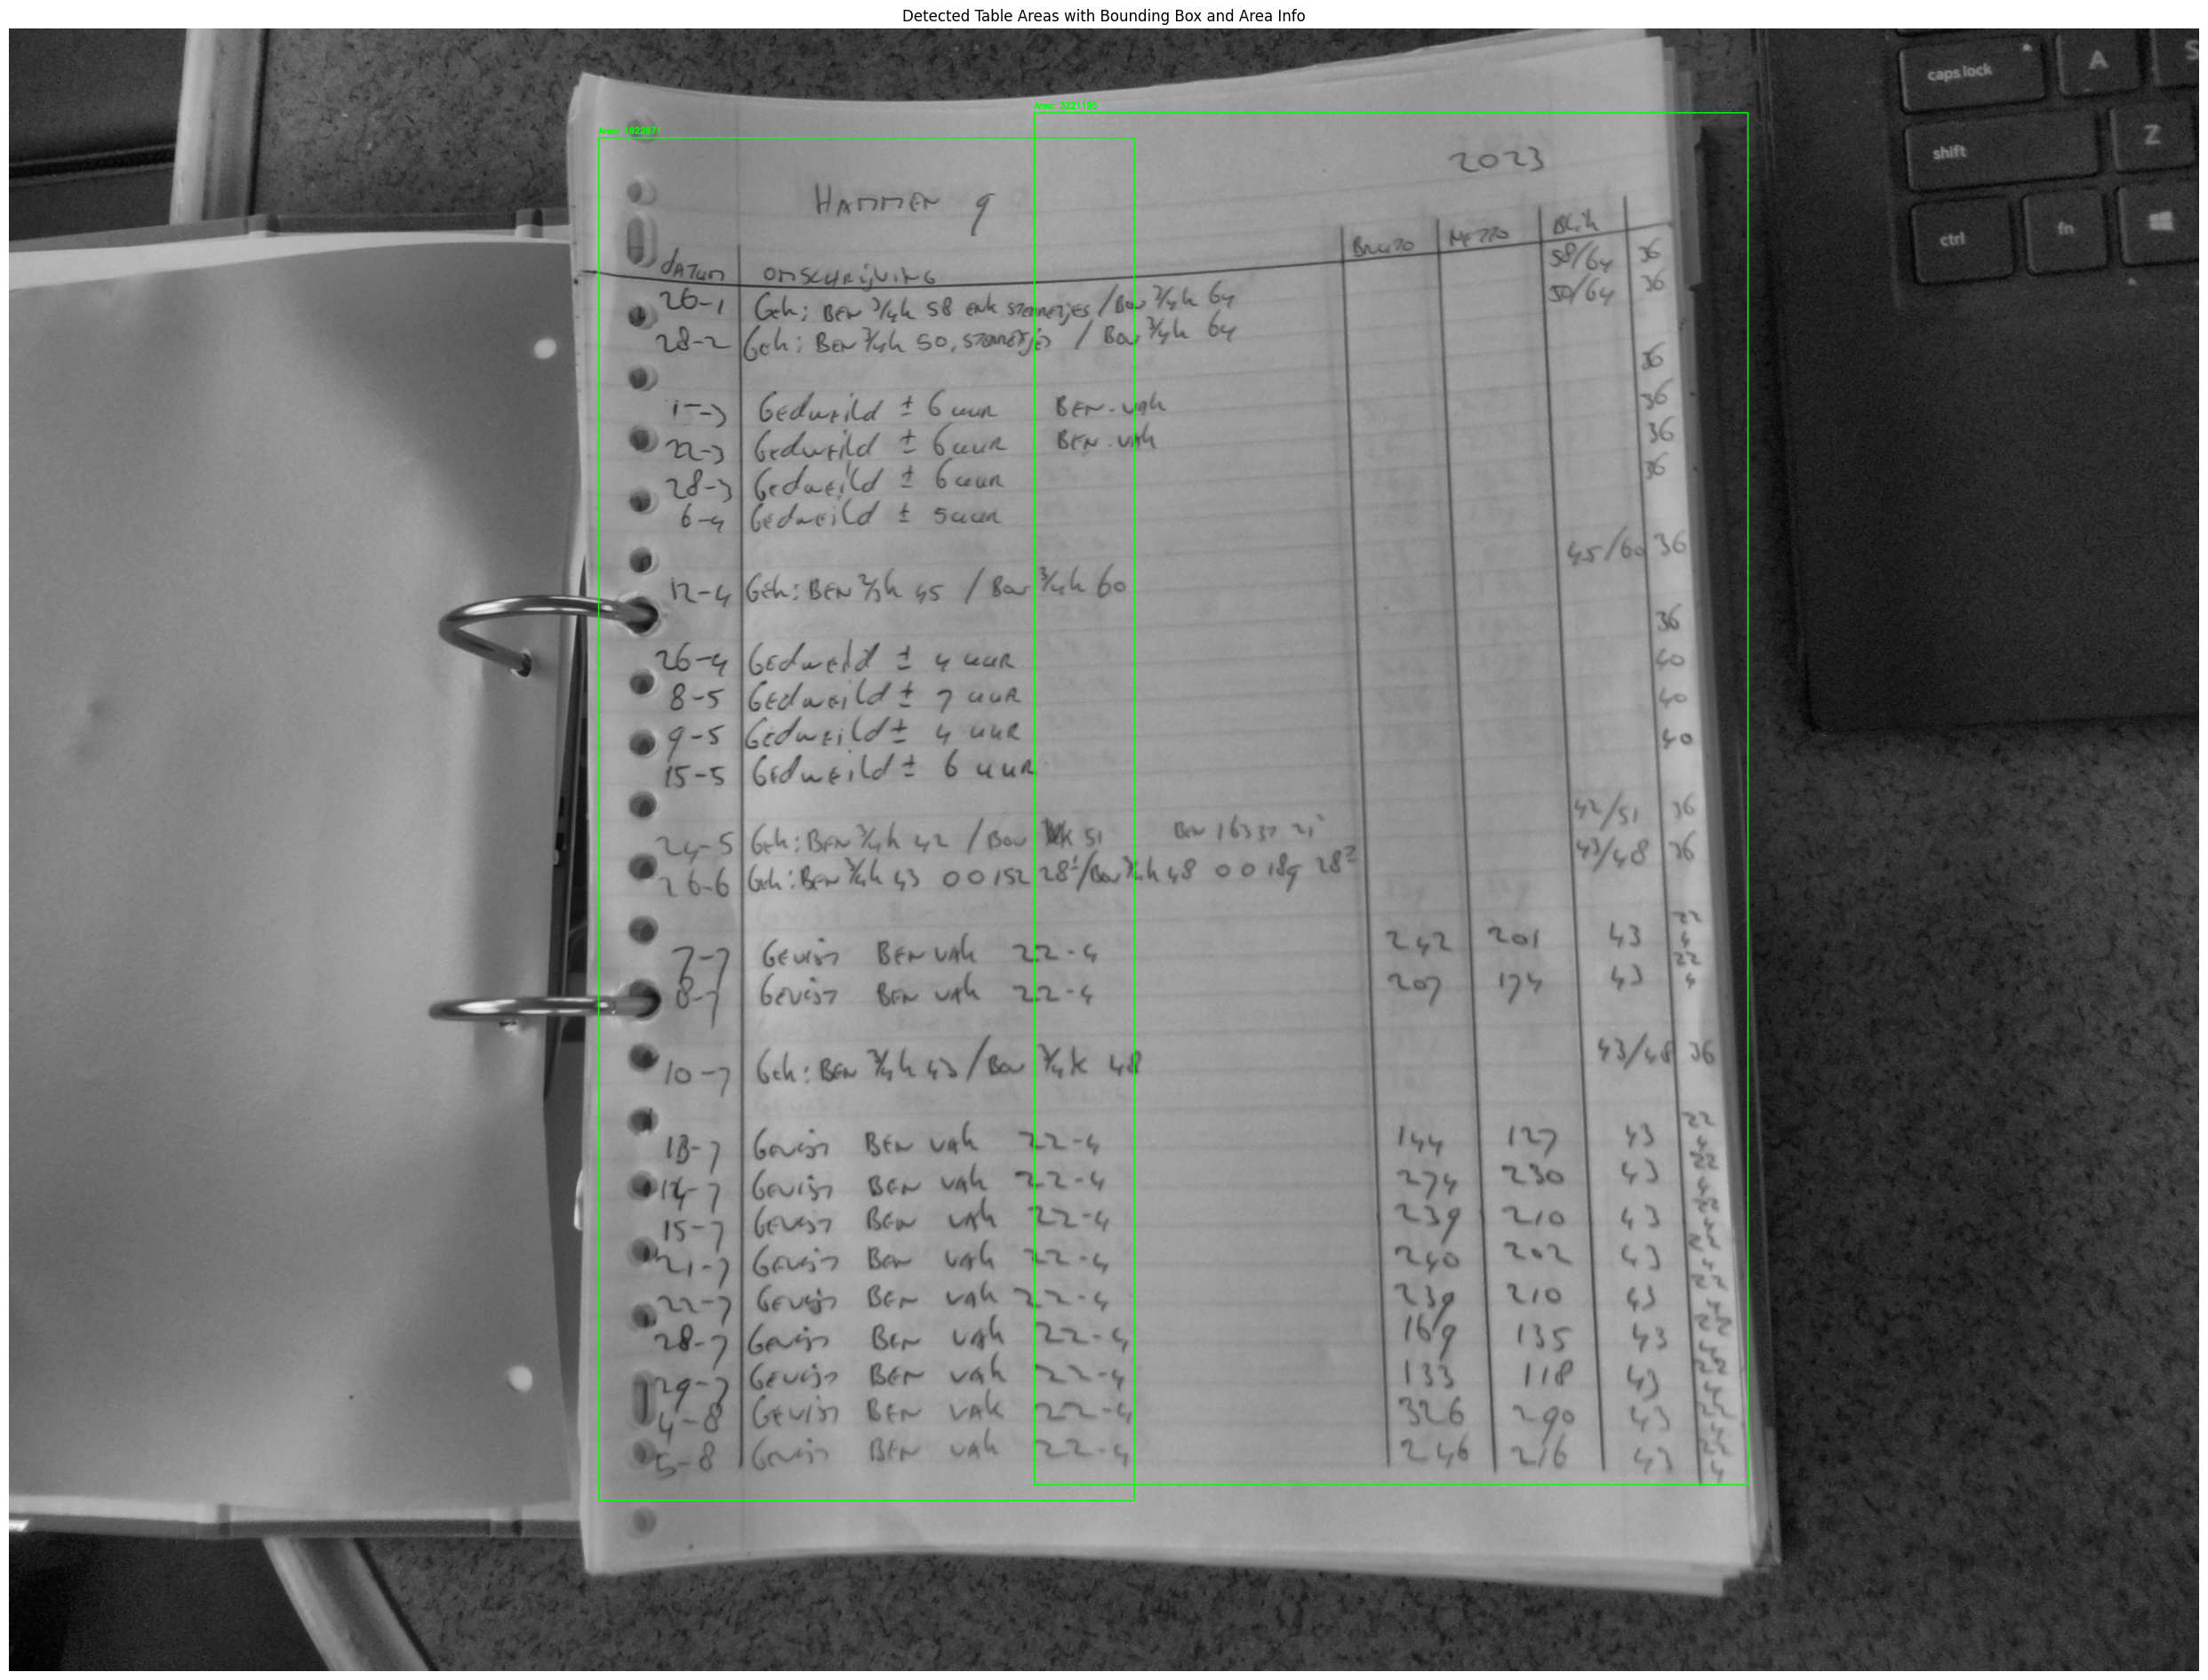

In [13]:
# Detect and optionally visualize table areas with optimized flow
large_contours = process_table_detection_and_visualization(
    mask=table_mask, 
    image=original_image, 
    threshold=0.1, 
    min_area=150000, 
    visualize=True
)

### Detect Combined Table Area

#### *Function*

In [14]:
def detect_combined_table_area(contours, padding=20):
    """
    Combine all detected table contours into one bounding box.

    Parameters:
        contours (list): Contours of detected table areas.
        padding (int): Padding around the combined bounding box.

    Returns:
        tuple: Combined bounding box (x, y, x2, y2).
    """
    if not contours:
        return None
    
    # Step 1: Initialize the combined bounding box with the first contour
    x, y, w, h = cv2.boundingRect(contours[0])
    combined_bbox = [x, y, x + w, y + h]
    
    # Step 2: Combine all bounding boxes
    for contour in contours[1:]:
        x, y, w, h = cv2.boundingRect(contour)
        combined_bbox[0] = min(combined_bbox[0], x)
        combined_bbox[1] = min(combined_bbox[1], y)
        combined_bbox[2] = max(combined_bbox[2], x + w)
        combined_bbox[3] = max(combined_bbox[3], y + h)
    
    # Step 3: Add padding to the combined bounding box
    combined_bbox[0] = max(0, combined_bbox[0] - padding)
    combined_bbox[1] = max(0, combined_bbox[1] - padding)
    combined_bbox[2] += padding
    combined_bbox[3] += padding
    
    return combined_bbox

#### *Implementation*

In [15]:
combined_bbox = detect_combined_table_area(large_contours)

### Visualize Combined Table Area

#### *Function*

In [16]:
def visualize_combined_table_area(image, combined_bbox):
    """
    Visualize the combined bounding box on the original image using Matplotlib.

    Parameters:
        image (np.array): Original image.
        combined_bbox (tuple): Combined bounding box (x, y, x2, y2).
    """
    # Step 1: Copy the original image for visualization
    vis_image = image.copy()

    # Step 2: Draw the combined bounding box in green
    x, y, x2, y2 = combined_bbox
    cv2.rectangle(vis_image, (x, y), (x2, y2), (0, 255, 0), 2)  # Green bounding box
    
    # Step 3: Display the image with the combined bounding box using Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(vis_image)
    plt.title('Combined Table Area')
    plt.axis('off')  # Hide axis for cleaner visualization
    plt.show()

#### *Implementation*

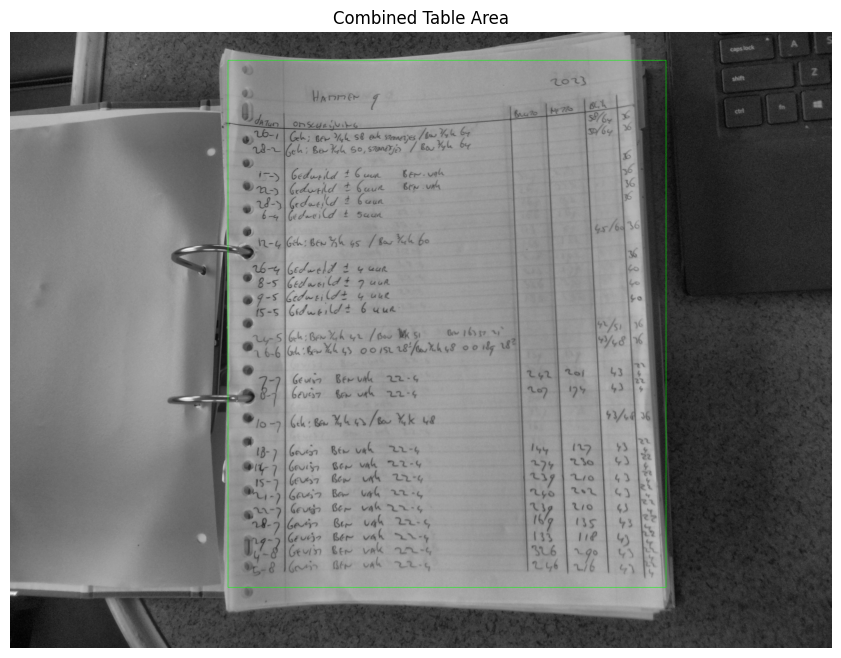

In [17]:
# Step 1: Detect the combined bounding box from the contours
combined_bbox = detect_combined_table_area(large_contours, padding=20)

# Step 2: Visualize the combined bounding box on the original image
if combined_bbox:
    visualize_combined_table_area(original_image, combined_bbox)
else:
    print("No combined bounding box detected.")

### Crop Table Areas Based on Detected Bounding Box

#### *Function*

In [18]:
def crop_table_area(image, bbox):
    """
    Crop the table area from the image using the combined bounding box.

    Parameters:
        image (np.array): Original image where tables are detected.
        bbox (tuple): Bounding box coordinates (x, y, x2, y2) for the table area.

    Returns:
        np.array: Cropped table image.
    """
    # Step 1: Extract the bounding box coordinates
    x, y, x2, y2 = bbox
    
    # Step 2: Crop the image based on the bounding box
    cropped_image = image[y:y2, x:x2]
    
    # Step 3: Visualize the cropped table area
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_image)
    plt.title('Cropped Table Area')
    plt.axis('off')
    plt.show()
    
    return cropped_image

#### *Implementation*

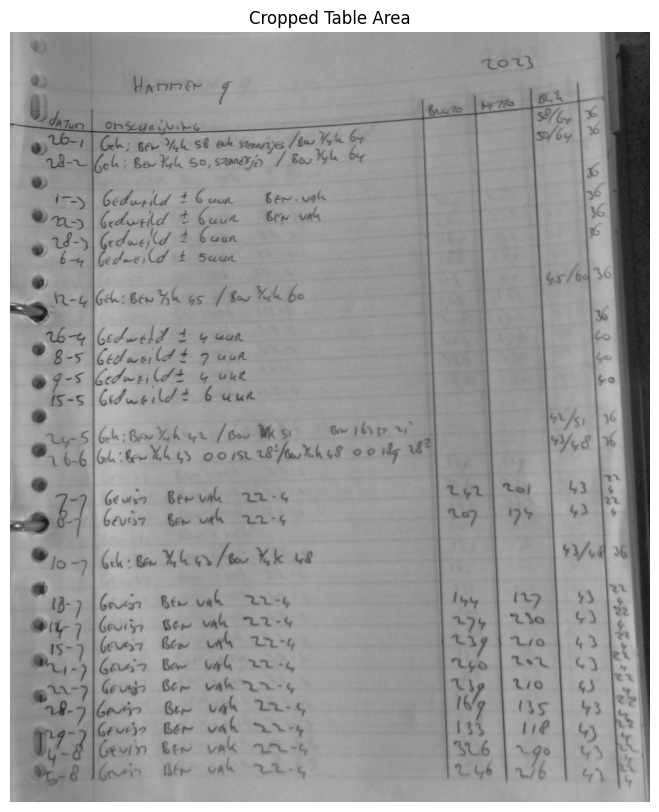

In [19]:
if combined_bbox:
    cropped_table_image = crop_table_area(original_image, combined_bbox)
else:
    print("No combined table area detected.")

### Perform OCR on the Cropped Table and Visualize

#### *Function*

In [20]:
def perform_and_visualize_ocr(image, confidence_threshold=40):
    """
    Perform OCR on the table image and visualize the results with predicted text in bounding boxes.
    
    Parameters:
        image (np.array): Original table image.
        confidence_threshold (int): Confidence threshold to filter OCR results.
    
    Returns:
        str: Detected text string.
    """
    # Convert the image to PIL format for Pytesseract
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Define multiple OCR configurations
    configs = [
        r'--oem 3 --psm 6',
        r'--oem 3 --psm 4',
        r'--oem 3 --psm 3',
        r'--oem 3 --psm 11',
        r'--oem 3 --psm 12'
    ]
    
    all_text = []
    all_boxes = []
    
    for config in configs:
        custom_config = f"{config} -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,()-_/%' "
        ocr_result = pytesseract.image_to_data(pil_image, config=custom_config, output_type=pytesseract.Output.DICT)
        
        for i in range(len(ocr_result['text'])):
            if int(ocr_result['conf'][i]) >= confidence_threshold:
                text = ocr_result['text'][i]
                if text.strip():
                    all_text.append(text)
                    all_boxes.append((
                        ocr_result['left'][i],
                        ocr_result['top'][i],
                        ocr_result['width'][i],
                        ocr_result['height'][i],
                        text
                    ))
    
    # Visualize results
    vis_image = image.copy()
    for (x, y, w, h, text) in all_boxes:
        # Draw thin blue bounding box
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), (255, 0, 0), 1)  # Blue color, thickness 1
        
        # Prepare text background
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.3, 1)
        text_offset_x = x
        text_offset_y = y - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
        cv2.rectangle(vis_image, box_coords[0], box_coords[1], (255, 0, 0), cv2.FILLED)  # Blue background
        
        # Put text
        cv2.putText(vis_image, text, (text_offset_x, text_offset_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title(f"OCR Result Visualization")
    plt.axis('off')
    plt.show()
    
    detected_text_str = ' '.join(all_text)
    print("Detected Text:")
    print(detected_text_str)
    
    return detected_text_str

#### *Implementation*

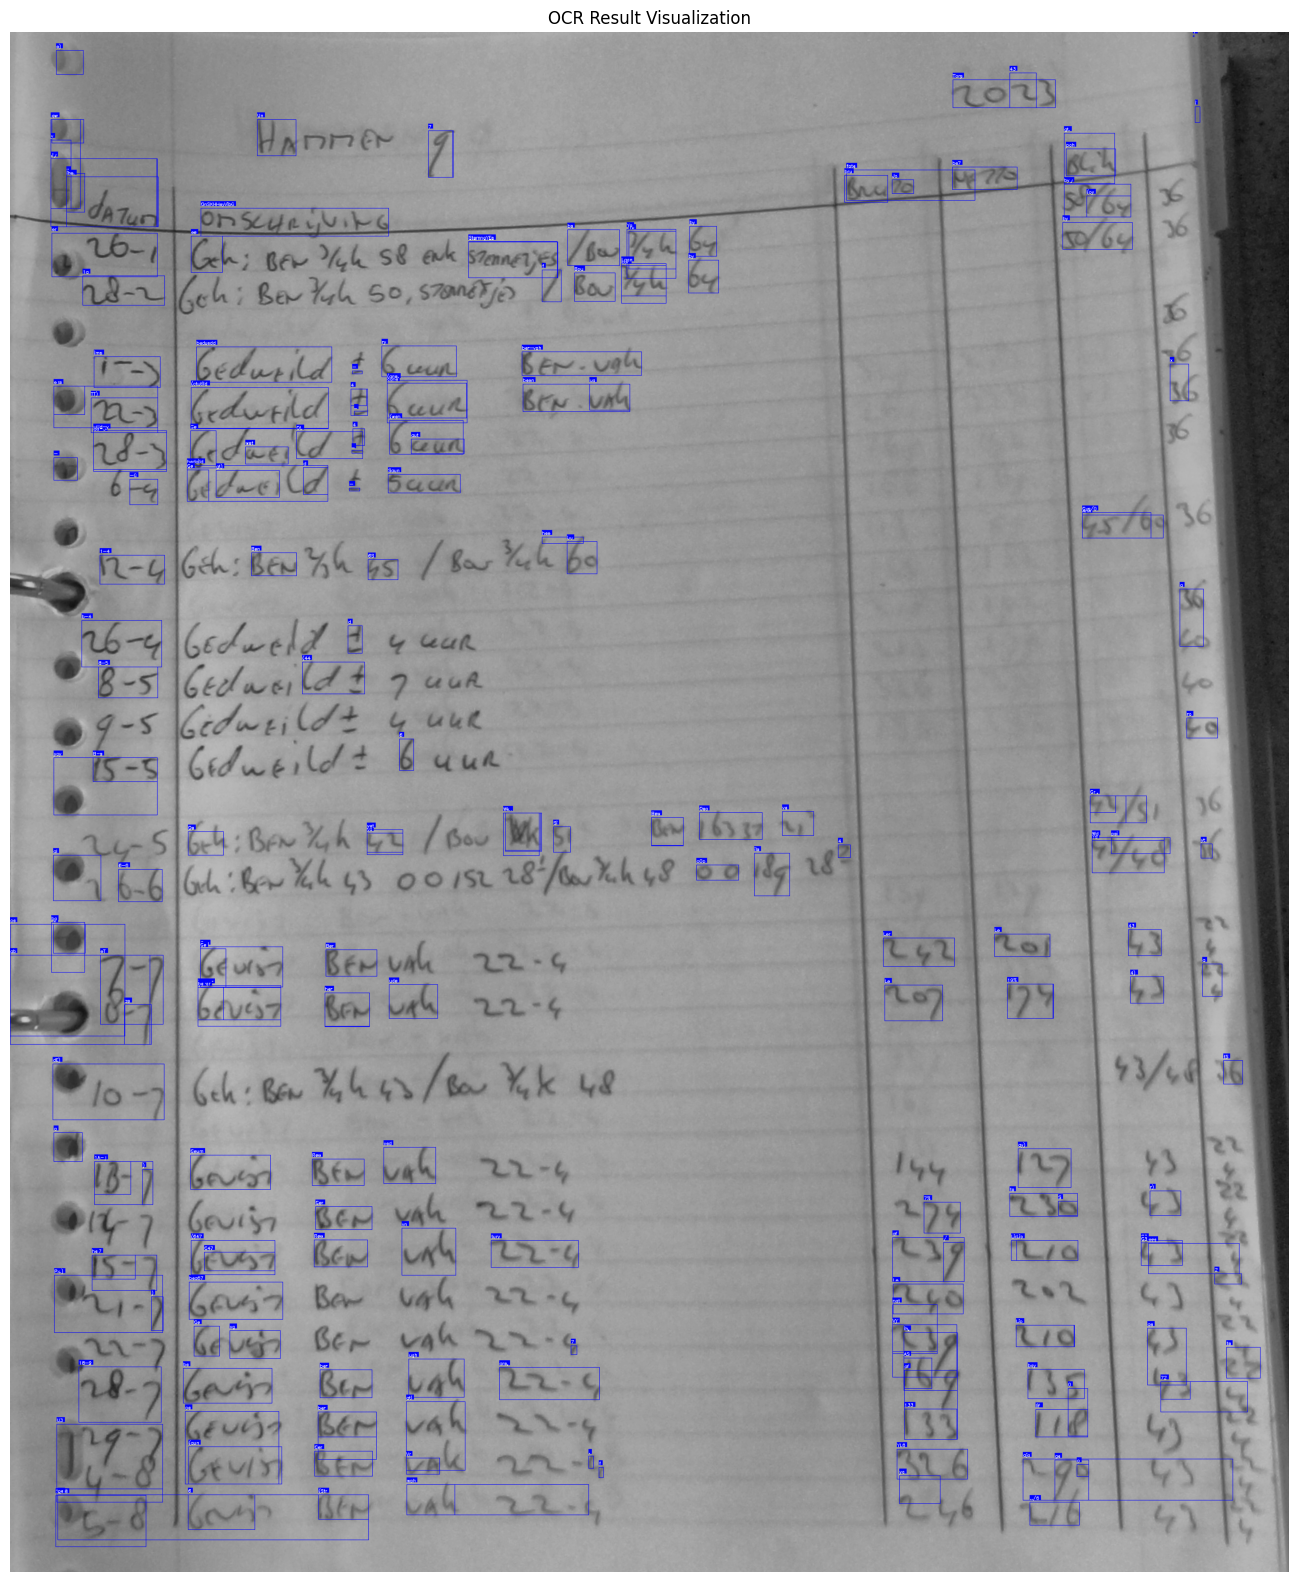

Detected Text:
e) 7 43 4 7 i y gt. ee (oy TT) (chutild cane x -G 1-4 Ben 6S bo erie a (44 yoy 6 ro ye Wk Si Cew Osa ve Ts 6 27 98 beaver her wn Ve 19% GS a a 1B-) Geum Rew ved 7% S r) / eee ) Le 2 nat es 18-9 be ber ugh LAG ih, ae te af 0 rat %,-8 rhe ya aja Lory 7 wy StemneYES Yb by f Bou Lan by ens i been ud-5 (wen - bedi hee b-4 yet Wk Si Bew ve 4 al 6-6 ils Gen Ber 43 6 ab 4) a s-7 (647 ew vn tury af G3 Lio 77 oe Ber ati 13% lid a e) Tors y Un 7 ihe. OnSKHHeyVibG fate Wey StemneYES Yb by 1a Laan by ims bedusdd ber-vah uUd-y Ge wet OL bedcild b-4 Oe Wk Si psi 6-6 oOo ils Yd ba eT as bevar her ual Le 19% 3 a af Px.) by Lio 77 oe Ber ati 13% lid 16 oe ew 7 poh bru Jo be7 J by by er StemngYEs bs Ya - ry ber-vah 4 _ ua e (ctutild (ane. _ 4 aut - Saun Ge gt) d Gxs/0 d 8-5 B-s ve 7%, ils Le 43 Ge Ler 4) oe be ude dE) Rew ved ay) 1A- ) Geum to Ger he C47 Rew Lio G3 bea67 7 VY Lio Ge vg ber AS bay are, 72 ber 133 lif (aun Cer Vr . f YL6 U3 ge 6 (Str wah ../6 ew 7 poh bru Jo be7 J by by er S

In [21]:
# Perform OCR and visualize the results in one step
ocr_result = perform_and_visualize_ocr(cropped_table_image, confidence_threshold=1)

### (Optional) Test Typed Data Table

In [22]:
def load_image(image_path):
    """
    Loads an image from the specified file path, converts it to a bytes-like object,
    and returns the image as a NumPy array.

    Args:
        image_path (str): Path to the image file.

    Returns:
        np.ndarray: The image in NumPy array format.
    """
    try:
        # Open the image and load it into a BytesIO object
        img = Image.open(image_path)
        
        # Optionally convert to array (NumPy)
        img_np = np.array(img)
        
        return img_np
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

In [23]:
ocr_image_path = "../data/10.1.1.1.2018_4.jpeg"
ocr_image = load_image(ocr_image_path)

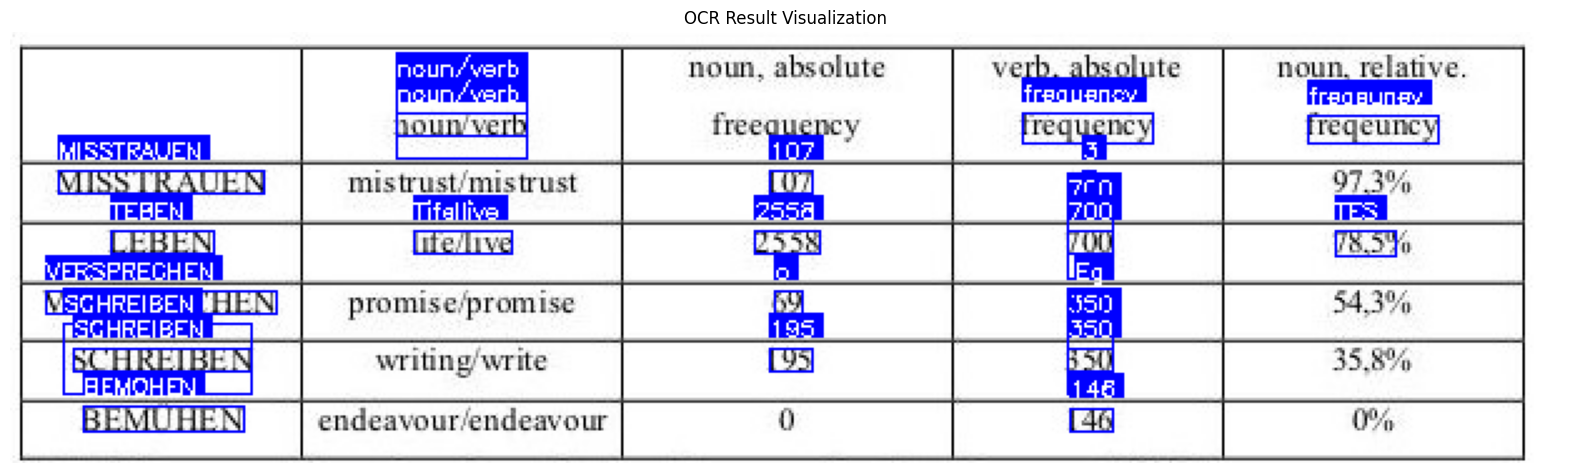

Detected Text:
noun/verb frequency freqeuney 107 3 TEBEN 2558 700 TES Eg SCHREIBEN 195 350 146 noun/verb frequency freqeuney 107 3 TEBEN 2558 700 TES Eg SCHREIBEN 195 350 146 noun/verb frequency freqeuney MISSTRAUEN 107 3 TEBEN Tifellive 2558 700 TES VERSPRECHEN o Eg SCHREIBEN 195 350 BEMOHEN 146 noun/verb frequency freqeuney MISSTRAUEN 107 3 TEBEN Tifellive 2558 700 TES VERSPRECHEN o Eg SCHREIBEN 195 350 BEMOHEN 146


In [24]:
# Perform OCR and visualize the results in one step
ocr_result = perform_and_visualize_ocr(ocr_image, confidence_threshold=40)